# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, count, when, isnan, when, asc, floor, desc, row_number
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,  BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('ProjectSparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Loading Dataset
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
# Schema of data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [6]:
df.count()

286500

In [7]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [8]:
df.select(["userID"]).dropDuplicates().describe().show()

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|               226|
|   mean|65391.013333333336|
| stddev|105396.47791907164|
|    min|                  |
|    max|                99|
+-------+------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [10]:
df.select("page").distinct().show(truncate = False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
+-------------------------+
only showing top 20 rows



In [11]:
df.where(df.userId==9).select(["song","status","level","page"]).show(30)

+--------------------+------+-----+-----------+
|                song|status|level|       page|
+--------------------+------+-----+-----------+
|              Canada|   200| free|   NextSong|
|Knocking On Forbi...|   200| free|   NextSong|
|      Don't Leave Me|   200| free|   NextSong|
|         Run Run Run|   200| free|   NextSong|
|   Walk On The Water|   200| free|   NextSong|
|                null|   200| free|Roll Advert|
|      Gettin' Better|   200| free|   NextSong|
|                null|   307| free|  Thumbs Up|
| You've Got The Love|   200| free|   NextSong|
|              Swisha|   200| free|   NextSong|
|        Sticky Sweet|   200| free|   NextSong|
|               Smile|   200| free|   NextSong|
|              Closer|   200| free|   NextSong|
|     Demasiado Bueno|   200| free|   NextSong|
|  Whoa! Shut It Down|   200| free|   NextSong|
|     World Long Gone|   200| free|   NextSong|
|                null|   307| free|Thumbs Down|
|                  22|   200| free|   Ne

In [12]:
cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [13]:
time_window = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [14]:
df = df.withColumn("is_cancelled", cancellation_event("page"))

In [15]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|is_cancelled|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|           0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331

In [16]:
df = df.withColumn("is_churn", fmax("is_cancelled").over(time_window))

In [17]:
df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+------------+--------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|is_cancelled|is_churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+------------+--------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|           0|       0|
|Francesca Battist...|Lo

In [18]:
df.select("userId","is_churn").dropDuplicates().show(5)

+------+--------+
|userId|is_churn|
+------+--------+
|100010|       0|
|200002|       0|
|   125|       1|
|   124|       0|
|    51|       1|
+------+--------+
only showing top 5 rows



In [19]:
non_downgraded_users = df.where(df.is_churn == 0)
downgraded_users = df.where(df.is_churn ==1)

In [20]:
cancelled_users_count = downgraded_users.select("userId").dropDuplicates().count()
non_cancelled_users_count = non_downgraded_users.select("userId").dropDuplicates().count()

print("Number of cancelled customers: ", cancelled_users_count)
print("Number of non cancelled customers: ", non_cancelled_users_count)

Number of cancelled customers:  52
Number of non cancelled customers:  174


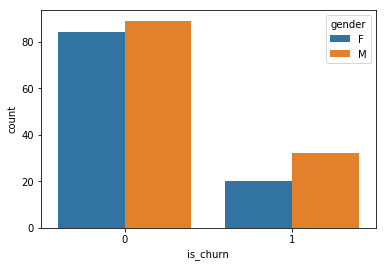

In [21]:
gender_df = df.select(["userId","gender","is_churn"]).dropDuplicates().toPandas()
sns.countplot(x = "is_churn", hue = "gender", data = gender_df)

In [22]:
non_downgraded_event_counts = non_downgraded_users.groupby("page").count()

In [23]:
downgraded_event_counts = downgraded_users.groupby("page").count()

In [24]:
downgraded_event_counts = downgraded_event_counts.withColumnRenamed("count", "downgraded_users_count")
non_downgraded_event_counts = non_downgraded_event_counts.withColumnRenamed("count", "non_downgraded_users_count")

In [25]:
downgraded_event_counts.show(2)

+----------------+----------------------+
|            page|downgraded_users_count|
+----------------+----------------------+
|          Cancel|                    52|
|Submit Downgrade|                     9|
+----------------+----------------------+
only showing top 2 rows



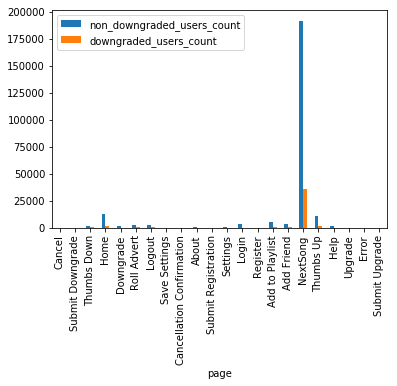

In [26]:
pandas_for_chart = non_downgraded_event_counts.join(downgraded_event_counts, "page", "outer").toPandas().fillna(0)
pandas_for_chart.plot.bar("page")

In [27]:
# Without next song event
non_downgraded_event_counts_without_song = non_downgraded_users.filter(non_downgraded_users["page"] != "NextSong").groupby("page").count()
downgraded_event_counts_without_song = downgraded_users.filter(downgraded_users["page"] != "NextSong").groupby("page").count()

In [69]:
downgraded_event_counts_without_song = downgraded_event_counts_without_song.withColumnRenamed("count", "downgraded_users_count")
non_downgraded_event_counts_without_song = non_downgraded_event_counts_without_song.withColumnRenamed("count", "non_downgraded_users_count")

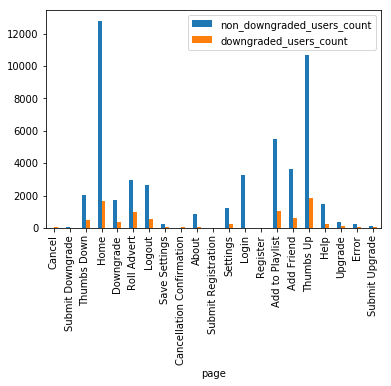

In [70]:
pandas_for_chart = non_downgraded_event_counts_without_song.join(downgraded_event_counts_without_song, "page", "outer").toPandas().fillna(0)
pandas_for_chart.plot.bar("page")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
is_nextSong_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
df = df.withColumn("is_NextSong", is_nextSong_event("page"))

is_Home_event = udf(lambda x: 1 if x == "Home" else 0, IntegerType())
df = df.withColumn("is_Home", is_Home_event("page"))

is_ThumbsUp_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
df = df.withColumn("is_ThumbsUp", is_ThumbsUp_event("page"))

is_AddFriend_event = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
df = df.withColumn("is_AddFriend", is_AddFriend_event("page"))

is_AddPlaylist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
df = df.withColumn("is_AddPlaylist", is_AddPlaylist_event("page"))

In [30]:
df.show(2, vertical=True)

-RECORD 0------------------------------
 artist         | Sleeping With Sirens 
 auth           | Logged In            
 firstName      | Darianna             
 gender         | F                    
 itemInSession  | 0                    
 lastName       | Carpenter            
 length         | 202.97098            
 level          | free                 
 location       | Bridgeport-Stamfo... 
 method         | PUT                  
 page           | NextSong             
 registration   | 1538016340000        
 sessionId      | 31                   
 song           | Captain Tyin Knot... 
 status         | 200                  
 ts             | 1539003534000        
 userAgent      | "Mozilla/5.0 (iPh... 
 userId         | 100010               
 is_cancelled   | 0                    
 is_churn       | 0                    
 is_NextSong    | 1                    
 is_Home        | 0                    
 is_ThumbsUp    | 0                    
 is_AddFriend   | 0                    


In [31]:
# This is the same WindowVal as previously used in the notebook
windowval1 = Window.partitionBy("userId").orderBy(asc("ts"))\
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("songs_count", fsum("is_NextSong").over(windowval1))
df = df.withColumn("home_count", fsum("is_Home").over(windowval1))
df = df.withColumn("thumbsUp_count", fsum("is_ThumbsUp").over(windowval1))
df = df.withColumn("addFriend_count", fsum("is_AddFriend").over(windowval1))
df = df.withColumn("addPlaylist_count", fsum("is_AddPlaylist").over(windowval1))

In [32]:
df.show(2, vertical=True)

-RECORD 0---------------------------------
 artist            | Sleeping With Sirens 
 auth              | Logged In            
 firstName         | Darianna             
 gender            | F                    
 itemInSession     | 0                    
 lastName          | Carpenter            
 length            | 202.97098            
 level             | free                 
 location          | Bridgeport-Stamfo... 
 method            | PUT                  
 page              | NextSong             
 registration      | 1538016340000        
 sessionId         | 31                   
 song              | Captain Tyin Knot... 
 status            | 200                  
 ts                | 1539003534000        
 userAgent         | "Mozilla/5.0 (iPh... 
 userId            | 100010               
 is_cancelled      | 0                    
 is_churn          | 0                    
 is_NextSong       | 1                    
 is_Home           | 0                    
 is_ThumbsU

In [33]:
df = df.withColumn("MaxTime", fmax("ts").over(windowval1))
df = df.withColumn("TimeFromEnd", df.MaxTime - df.ts)

In [34]:
df.show(1, vertical=True)

-RECORD 0---------------------------------
 artist            | Sleeping With Sirens 
 auth              | Logged In            
 firstName         | Darianna             
 gender            | F                    
 itemInSession     | 0                    
 lastName          | Carpenter            
 length            | 202.97098            
 level             | free                 
 location          | Bridgeport-Stamfo... 
 method            | PUT                  
 page              | NextSong             
 registration      | 1538016340000        
 sessionId         | 31                   
 song              | Captain Tyin Knot... 
 status            | 200                  
 ts                | 1539003534000        
 userAgent         | "Mozilla/5.0 (iPh... 
 userId            | 100010               
 is_cancelled      | 0                    
 is_churn          | 0                    
 is_NextSong       | 1                    
 is_Home           | 0                    
 is_ThumbsU

In [35]:
# Week from end is the number of weeks of usage before the user's last activity. 

no_of_weeks = udf(lambda x: x/604800000)
df  = df.withColumn("no_of_weeks", no_of_weeks("TimeFromEnd"))
df = df.withColumn("no_of_weeks_int",floor(df.no_of_weeks))

In [36]:
df.show(1, vertical=True)

-RECORD 0---------------------------------
 artist            | Sleeping With Sirens 
 auth              | Logged In            
 firstName         | Darianna             
 gender            | F                    
 itemInSession     | 0                    
 lastName          | Carpenter            
 length            | 202.97098            
 level             | free                 
 location          | Bridgeport-Stamfo... 
 method            | PUT                  
 page              | NextSong             
 registration      | 1538016340000        
 sessionId         | 31                   
 song              | Captain Tyin Knot... 
 status            | 200                  
 ts                | 1539003534000        
 userAgent         | "Mozilla/5.0 (iPh... 
 userId            | 100010               
 is_cancelled      | 0                    
 is_churn          | 0                    
 is_NextSong       | 1                    
 is_Home           | 0                    
 is_ThumbsU

In [37]:
#Create a column which is grouped by userId and the week (defined as weeks before the last user activity)
#providing a sum of each page activity of interest in that particular week. 

window_for_a_week = Window.partitionBy(["userId", "no_of_weeks_int"]).orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("songs_in_a_week", fsum("is_NextSong").over(window_for_a_week))
df = df.withColumn("home_in_a_week", fsum("is_Home").over(window_for_a_week))
df = df.withColumn("thumbsUp_in_a_week", fsum("is_ThumbsUp").over(window_for_a_week))
df = df.withColumn("addFriends_in_a_week", fsum("is_AddFriend").over(window_for_a_week))
df = df.withColumn("addPlaylist_in_a_week", fsum("is_AddPlaylist").over(window_for_a_week))

In [38]:
df.show(2)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------------+--------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+-------------+-----------+--------------------+---------------+---------------+--------------+------------------+--------------------+---------------------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|is_cancelled|is_churn|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|      MaxTime|TimeFromEnd|         no_of_weeks|no_of_weeks_int|songs_in_a_week|home_in_a_week|thumbsUp_in_a_week|ad

In [39]:
window_session = Window.partitionBy("userId","sessionId").orderBy(desc("ts"))\
                   .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
window_user = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("session_length",fmax("itemInSession").over(window_session))
df_sessionLen = df.select("userId","session_length","sessionId").dropDuplicates()\
.withColumn("avg_session_length",avg("session_length").over(window_user)).drop("sessionId","sessionLen").dropDuplicates()
df_sessionLen.show(10)

+------+--------------+------------------+
|userId|session_length|avg_session_length|
+------+--------------+------------------+
|100010|           111| 54.42857142857143|
|100010|            39| 54.42857142857143|
|100010|            59| 54.42857142857143|
|100010|             8| 54.42857142857143|
|100010|            73| 54.42857142857143|
|100010|            34| 54.42857142857143|
|100010|            57| 54.42857142857143|
|200002|           157|              80.0|
|200002|             6|              80.0|
|200002|           143|              80.0|
+------+--------------+------------------+
only showing top 10 rows



In [40]:
df.show(1, vertical=True)

-RECORD 0----------------------------------
 artist                | null              
 auth                  | Logged Out        
 firstName             | null              
 gender                | null              
 itemInSession         | 1                 
 lastName              | null              
 length                | null              
 level                 | free              
 location              | null              
 method                | PUT               
 page                  | Login             
 registration          | null              
 sessionId             | 164               
 song                  | null              
 status                | 307               
 ts                    | 1541186398000     
 userAgent             | null              
 userId                |                   
 is_cancelled          | 0                 
 is_churn              | 0                 
 is_NextSong           | 0                 
 is_Home               | 0      

In [41]:
#Add the membership status of the customer at their last action

window_ts = Window.partitionBy("userId").orderBy(desc("ts"))
df = df.withColumn("row_no",row_number().over(window_ts))
df_membership_status = df.select("userId","row_no","level").where(df["row_no"]==1)\
                      .drop("row_no").dropDuplicates()
df_membership_status = df_membership_status.select("userId",col("level").alias("final_level"))

In [42]:
df_membership_status.show(5)

+------+-----------+
|userId|final_level|
+------+-----------+
|100010|       free|
|200002|       paid|
|   125|       free|
|   124|       paid|
|    51|       paid|
+------+-----------+
only showing top 5 rows



In [43]:
print(df_membership_status.count())
print(df_sessionLen.count())

226
3249


In [44]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, is_cancelled: string, is_churn: string, is_NextSong: string, is_Home: string, is_ThumbsUp: string, is_AddFriend: string, is_AddPlaylist: string, songs_count: string, home_count: string, thumbsUp_count: string, addFriend_count: string, addPlaylist_count: string, MaxTime: string, TimeFromEnd: string, no_of_weeks: string, no_of_weeks_int: string, songs_in_a_week: string, home_in_a_week: string, thumbsUp_in_a_week: string, addFriends_in_a_week: string, addPlaylist_in_a_week: string, session_length: string, row_no: string]

In [45]:
df_clean = df.drop("artist","auth","itemInSession","length","level","location","method","page","registration","sessionId",\
                  "song","status","ts","userAgent","time","hour","weekday","day","Cancelled","NextSong","Home","ThumbsUp",\
                  "AddFriend","AddPlaylist","TimeFromEnd","session_length","row_no").dropDuplicates()

In [46]:
df_clean.show(1, vertical=True)

-RECORD 0-------------------------------------
 firstName             | Samuel               
 gender                | M                    
 lastName              | Green                
 userId                | 149                  
 is_cancelled          | 0                    
 is_churn              | 0                    
 is_NextSong           | 1                    
 is_Home               | 0                    
 is_ThumbsUp           | 0                    
 is_AddFriend          | 0                    
 is_AddPlaylist        | 0                    
 songs_count           | 186                  
 home_count            | 7                    
 thumbsUp_count        | 11                   
 addFriend_count       | 9                    
 addPlaylist_count     | 5                    
 MaxTime               | 1540970447000        
 no_of_weeks           | 0.021805555555555557 
 no_of_weeks_int       | 0                    
 songs_in_a_week       | 54                   
 home_in_a_we

In [47]:
df_pivot = df_clean.where(df_clean.no_of_weeks_int <=3).groupBy('userId').pivot('no_of_weeks_int')\
                  .agg(first('songs_in_a_week').alias('total_song_event_in_a_week'),first('home_in_a_week').alias('total_home_in_a_week'),\
                       first('thumbsUp_in_a_week').alias('total_like_in_a_week'),first('addFriends_in_a_week')\
                       .alias('total_addFriends_in_a_week'),first('addPlaylist_in_a_week').alias('total_addPlaylist_in_a_week'))

In [48]:
df_final = df_clean.drop("MaxTime","no_of_weeks","no_of_weeks_int","songs_in_a_week","home_in_a_week","thumbsUp_in_a_week",\
                       "addFriends_in_a_week","addPlaylist_in_a_week").dropDuplicates()

In [49]:
df_final.printSchema()


root
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- is_cancelled: integer (nullable = true)
 |-- is_churn: integer (nullable = true)
 |-- is_NextSong: integer (nullable = true)
 |-- is_Home: integer (nullable = true)
 |-- is_ThumbsUp: integer (nullable = true)
 |-- is_AddFriend: integer (nullable = true)
 |-- is_AddPlaylist: integer (nullable = true)
 |-- songs_count: long (nullable = true)
 |-- home_count: long (nullable = true)
 |-- thumbsUp_count: long (nullable = true)
 |-- addFriend_count: long (nullable = true)
 |-- addPlaylist_count: long (nullable = true)



In [50]:
print(df_final.count())
print(df_pivot.count())

1367
226


In [51]:
df_pivot.show(1, vertical = True)

-RECORD 0-------------------------------
 userId                        | 200002 
 0_total_song_event_in_a_week  | 120    
 0_total_home_in_a_week        | 6      
 0_total_like_in_a_week        | 6      
 0_total_addFriends_in_a_week  | 0      
 0_total_addPlaylist_in_a_week | 2      
 1_total_song_event_in_a_week  | null   
 1_total_home_in_a_week        | null   
 1_total_like_in_a_week        | null   
 1_total_addFriends_in_a_week  | null   
 1_total_addPlaylist_in_a_week | null   
 2_total_song_event_in_a_week  | null   
 2_total_home_in_a_week        | null   
 2_total_like_in_a_week        | null   
 2_total_addFriends_in_a_week  | null   
 2_total_addPlaylist_in_a_week | null   
 3_total_song_event_in_a_week  | 92     
 3_total_home_in_a_week        | 4      
 3_total_like_in_a_week        | 4      
 3_total_addFriends_in_a_week  | 0      
 3_total_addPlaylist_in_a_week | 1      
only showing top 1 row



In [52]:
df_pivot.select([count(when(col(c).isNull(), c)).alias(c) for c in df_pivot.columns]).show()

+------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+
|userId|0_total_song_event_in_a_week|0_total_home_in_a_week|0_total_like_in_a_week|0_total_addFriends_in_a_week|0_total_addPlaylist_in_a_week|1_total_song_event_in_a_week|1_total_home_in_a_week|1_total_like_in_a_week|1_total_addFriends_in_a_week|1_total_addPlaylist_in_a_week|2_total_song_event_in_a_week|2_total_home_in_a_week|2_total_like_in_a_week|2_total_addFriends_in_a_week|2_total_addPlaylist_in_a_week|3_total_song_event_in_a_week|3_total_home_in_

In [53]:
# replacing null values with 0
df_pivot = df_pivot.fillna(0)
df_merged = df_final.join(df_pivot,"userId","left").join(df_sessionLen,"userId","left").\
          join(df_membership_status,"userId","left")

df_merged =  df_merged.withColumn("percIncreaseSong",(df_merged["0_total_song_event_in_a_week"])/\
           (df_merged["0_total_song_event_in_a_week"]+df_merged["1_total_song_event_in_a_week"]+df_merged["2_total_song_event_in_a_week"]+df_merged["3_total_song_event_in_a_week"]+1))
df_merged.show(5)

+------+---------+------+---------+------------+--------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+-------------------+
|userId|firstName|gender| lastName|is_cancelled|is_churn|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_

In [54]:
#Dropping unnecesarry columns, and making character variables numeric. 

df_features = df_merged.drop("MaxTime","no_of_weeks","no_of_weeks_int","songs_in_a_week","home_in_a_week","thumbsUp_in_a_week",\
                           "addFriends_in_a_week","addPlaylist_in_a_week").dropDuplicates()

In [55]:
df_features.show(1)

+------+---------+------+---------+------------+--------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+-------------------+
|userId|firstName|gender| lastName|is_cancelled|is_churn|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_

In [56]:
gender_dummy = udf(lambda x:1 if x == "M" else 0,IntegerType())
membershipStatus_dummy  = udf(lambda x:1 if x == "paid" else 0,IntegerType())

In [57]:
df_features = df_features.withColumn("gender",gender_dummy(df_features.gender))\
.withColumn("final_level",membershipStatus_dummy(df_features.final_level))
df_features.show(5)

+------+---------+------+---------+------------+--------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+-------------------+
|userId|firstName|gender| lastName|is_cancelled|is_churn|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_

In [58]:
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- lastName: string (nullable = true)
 |-- is_cancelled: integer (nullable = true)
 |-- is_churn: integer (nullable = true)
 |-- is_NextSong: integer (nullable = true)
 |-- is_Home: integer (nullable = true)
 |-- is_ThumbsUp: integer (nullable = true)
 |-- is_AddFriend: integer (nullable = true)
 |-- is_AddPlaylist: integer (nullable = true)
 |-- songs_count: long (nullable = true)
 |-- home_count: long (nullable = true)
 |-- thumbsUp_count: long (nullable = true)
 |-- addFriend_count: long (nullable = true)
 |-- addPlaylist_count: long (nullable = true)
 |-- 0_total_song_event_in_a_week: long (nullable = true)
 |-- 0_total_home_in_a_week: long (nullable = true)
 |-- 0_total_like_in_a_week: long (nullable = true)
 |-- 0_total_addFriends_in_a_week: long (nullable = true)
 |-- 0_total_addPlaylist_in_a_week: long (nullable = true)
 |-- 1_total_song_event_in_a_week: 

In [59]:
#Move the churn column to the end of the dataframe.
df_with_churn = df_features.select("userId", "is_churn")
df_without_churn = df_features.drop("is_churn")
final_df_with_churn = df_without_churn.join(df_with_churn, "userId", "left")

In [60]:
df_final_features = final_df_with_churn.drop("userId","firstName","lastName")

In [61]:
#Check for Nan values
df_final_features.select([count(when(isnan(c), c)).alias(c) for c in df_final_features.columns]).show()

+------+------------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+----------------+--------+
|gender|is_cancelled|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_in_a_week|0_total_home_in_a_week|0_total_like_in_a_week|0_total_ad

In [62]:
#Check for Null values
df_final_features.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final_features.columns]).show()

+------+------------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+----------------+--------+
|gender|is_cancelled|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_in_a_week|0_total_home_in_a_week|0_total_like_in_a_week|0_total_ad

In [63]:
df_final_features.show(2)

+------+------------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+-------------------+--------+
|gender|is_cancelled|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_in_a_week|0_total_home_in_a_week|0_total_like_in_a_week|0_total

In [64]:
df_final_features.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- is_cancelled: integer (nullable = true)
 |-- is_NextSong: integer (nullable = true)
 |-- is_Home: integer (nullable = true)
 |-- is_ThumbsUp: integer (nullable = true)
 |-- is_AddFriend: integer (nullable = true)
 |-- is_AddPlaylist: integer (nullable = true)
 |-- songs_count: long (nullable = true)
 |-- home_count: long (nullable = true)
 |-- thumbsUp_count: long (nullable = true)
 |-- addFriend_count: long (nullable = true)
 |-- addPlaylist_count: long (nullable = true)
 |-- 0_total_song_event_in_a_week: long (nullable = true)
 |-- 0_total_home_in_a_week: long (nullable = true)
 |-- 0_total_like_in_a_week: long (nullable = true)
 |-- 0_total_addFriends_in_a_week: long (nullable = true)
 |-- 0_total_addPlaylist_in_a_week: long (nullable = true)
 |-- 1_total_song_event_in_a_week: long (nullable = true)
 |-- 1_total_home_in_a_week: long (nullable = true)
 |-- 1_total_like_in_a_week: long (nullable = true)
 |-- 1_total_addFriends_in_a_week

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [65]:
features_list = df_final_features.columns[:]
for feature in features_list:
    df_final_features = df_final_features.withColumn(feature, df_final_features[feature].cast("float"))

In [66]:
assembler = VectorAssembler(inputCols=df_final_features.columns[:-1], outputCol="Features")
data = assembler.transform(df_final_features)

In [67]:
data.show(2)

+------+------------+-----------+-------+-----------+------------+--------------+-----------+----------+--------------+---------------+-----------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+----------------------------+----------------------+----------------------+----------------------------+-----------------------------+--------------+------------------+-----------+----------------+--------+--------------------+
|gender|is_cancelled|is_NextSong|is_Home|is_ThumbsUp|is_AddFriend|is_AddPlaylist|songs_count|home_count|thumbsUp_count|addFriend_count|addPlaylist_count|0_total_song_event_in_a_week|0_total_home_in_a_week|0_total_like

In [71]:
scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures", withStd=True)
scaler_trans = scaler.fit(data)

In [72]:
data = scaler_trans.transform(data)

data = data.select(data.is_churn.alias("label"), data.ScaledFeatures.alias("features"))

In [73]:
train, test = data.randomSplit([0.8,0.2], seed = 24)

In [74]:
from sklearn.metrics import f1_score, accuracy_score

In [75]:
def model_scores(model, model_name):
    '''A function to provide the F1 score of any trained model.
       input: model - The trained model with which to score
              model_name (str) - A string prefix that will appear in the output
       output: f1Score - The F1 Score of the model, on the validation data set.
    '''
    predictions = model.transform(test)
    predictions_pd = predictions.toPandas()
    model_f1_score = f1_score(predictions_pd.label,predictions_pd.prediction)
    model_accuracy_score = accuracy_score(predictions_pd.label,predictions_pd.prediction)
    print(model_name," F1 score: ",model_f1_score)
    print(model_name," Accuracy: ",model_accuracy_score)

In [76]:
def feature_importance_tree(model):
    '''This function will output the features most used in a tree based model. 
       This gives a good idea of the feature importance of the model
       
    '''
    feature_imp_list = list(model.bestModel.featureImportances)
    features_list = list(df_final_features.drop("is_churn").columns[:])

    importance_dict = {"feature":features_list,"importance_score":feature_imp_list}
    feature_importance = pd.DataFrame(importance_dict).sort_values(by = "importance_score", ascending = False)

    return (feature_importance.head(5))

In [87]:
params = ParamGridBuilder().addGrid(LogisticRegression().regParam,[0.1,0.2])\
                              .addGrid(LogisticRegression().elasticNetParam, [0.1,0.2])\
                              .addGrid(LogisticRegression().maxIter,[10])\
                              .build()

crossval = CrossValidator(estimator=LogisticRegression(),
                          estimatorParamMaps=params,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 100) 

logistic_regression_model = crossval.fit(train)
print("Logistic regression training complete")

Logistic regression training complete


In [88]:
logistic_regression_model.write().overwrite().save("logistic_regression_model.model")

In [89]:
logistic_regression_model = CrossValidatorModel.load('logistic_regression_model.model')

In [90]:
# For Logistic Regression Model
model_scores(logistic_regression_model,"Logistic_regression")

Logistic_regression  F1 score:  0.806754388193
Logistic_regression  Accuracy:  0.950343175491


In [83]:
import pandas as pd

In [92]:
coefficients = list(logistic_regression_model.bestModel.coefficients)
mag_coefficients = list(logistic_regression_model.bestModel.coefficients)
for i in range(len(coefficients)):
    mag_coefficients[i] = abs(mag_coefficients[i])

features = list(df_final_features.drop("is_churn").columns[:])

LR_Dict = {"Feature":features,"Importance_Score":coefficients, "Importance_mag":mag_coefficients}
LR_Feature_Importance = pd.DataFrame(LR_Dict).sort_values(by = "Importance_mag", ascending = False)
LR_Feature_Importance.head(10)

,Feature,Importance_Score,Importance_mag
9,thumbsUp_count,-30.412929,30.412929
27,3_total_song_event_in_a_week,13.559167,13.559167
29,3_total_like_in_a_week,-10.664686,10.664686
11,addPlaylist_count,10.589301,10.589301
14,0_total_like_in_a_week,9.478500,9.478500
19,1_total_like_in_a_week,6.359890,6.359890
10,addFriend_count,5.824378,5.824378
23,2_total_home_in_a_week,-5.681952,5.681952
8,home_count,-5.578425,5.578425
1,is_cancelled,5.209064,5.209064


In [94]:
RandomForestClassifier().explainParams()

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)

In [77]:
random_forest = RandomForestClassifier(seed = 24)

params = ParamGridBuilder().addGrid(random_forest.numTrees,[20,30])\
                              .addGrid(random_forest.impurity,["gini","entropy"])\
                              .addGrid(random_forest.minInstancesPerNode,[1,3])\
                              .build()

crossval = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=params,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

rf_model = crossval.fit(train)

print("Random forest training completed")

Random forest training completed


In [78]:
rf_model.write().overwrite().save('Random_forest_model.model')


In [79]:
rf_model = CrossValidatorModel.load('Random_forest_model.model')


In [81]:
# For random Forest Model
model_scores(rf_model,"RF")


RF  F1 score:  0.826420504937
RF  Accuracy:  0.961674657232


In [84]:
feature_importance_tree(rf_model)

,feature,importance_score
8,home_count,0.137660
28,3_total_home_in_a_week,0.096485
1,is_cancelled,0.071020
27,3_total_song_event_in_a_week,0.066747
18,1_total_home_in_a_week,0.066198


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
Link to the Blogpost: https://gunanksood.medium.com/building-a-feature-engineering-pipeline-and-ml-model-using-pyspark-7036375cd081
Github link to this project: https://github.com/gunanksood/Sparkify-ML_Pipeline